## Data preprocessing

In [34]:
# let's first start with adding the 'src' folder to the path file system
import os, sys
from pathlib import Path

current = Path(os.getcwd())
while 'src' not in os.listdir(current):
    current = current.parent

# now add the 'src' folder to the PATH variable
sys.path.append(str(current))
sys.path.append(str(os.path.join(current, 'src')))

In [35]:
# necessary imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter

# read train data
import os
data_folder = os.path.join(os.getcwd(), 'data') 
train_df = pd.read_csv(os.path.join(data_folder, 'mnist_train.csv'), header=None)
train_df.head()

# split images and labels
labels = train_df[0].values
images = train_df.drop([0], axis=1).values.reshape(-1, 28, 28) / 255

# Preprocess images
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor()])
images = train_df.drop([0], axis=1).values.reshape(-1, 28, 28) / 255
# convert data to tensors
images_tensor = torch.stack([transform(image).float() for image in images])
labels_tensor = torch.from_numpy(labels)

# just some checking of shapes
images_tensor.shape, labels_tensor.shape

(torch.Size([60000, 1, 28, 28]), torch.Size([60000]))

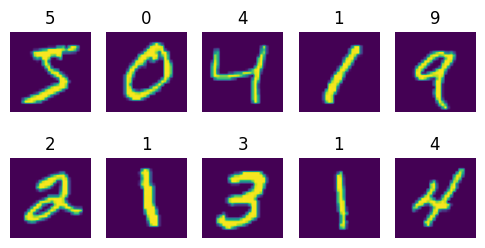

In [36]:
import matplotlib.pyplot as plt
def plot_images(images, captions=[], rows=2, columns=5, title="", **kwargs):
    """
    Plots images with captions

    :param images: list of images to plot
    :param captions: captions of images:
    :param rows: number of rows in figure
    :param columns: number of columns:
    :param title: super title of figure
    """
    fig = plt.figure(figsize=(6, 3))
    for i, img in enumerate(images):
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(img, **kwargs)
        if i < len(captions):
            plt.title(captions[i])
        plt.axis("off")
    fig.suptitle(title)
    plt.show()
    
# Visualise 10 images from the dataset
plot_images(images[:10], captions=labels[:10])

In [37]:
from torch.utils.data import TensorDataset, DataLoader, random_split
# images_tensor = torch.reshape(images_tensor,shape=(-1, 28 * 28))
processed_dataset = TensorDataset(images_tensor, torch.unsqueeze(labels_tensor, dim=-1))

# setting the seed
generator = torch.Generator().manual_seed(69)

train_dataset, val_dataset = random_split(processed_dataset, lengths=[0.85, 0.15], generator=generator)

# create a loader for each split 
batch_size = 128
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# if this line of code doesn't raise an error, we're good to go
iteration = next(iter(train_loader))

In [38]:
import warnings
import random
import torch

from typing import Union, Dict, Tuple
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler

def get_default_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu' 

ACCURACY = 'accuracy'


def accuracy(y_pred: torch.tensor, y: torch.tensor) -> float:
    # squeeze values if needed
    value = (y_pred == y).type(torch.float32).mean().item()
    return value

def _set_default_parameters(device: str = None,
                            metrics: Union[str, Dict[str, callable]] = None
                            ) -> Tuple[str, Dict[str, callable]]:
    # set default arguments
    device = get_default_device() if device is None else device

    # a None 'metrics' will map only to accuracy
    metrics = {ACCURACY: accuracy} if metrics is None else metrics

    return device, metrics


In [67]:
def train_per_epoch(model: nn.Module,
                    train_dataloader: DataLoader[torch.tensor],
                    loss_function: nn.Module,
                    optimizer: torch.optim.Optimizer,
                    output_layer: Union[nn.Module, callable],
                    scheduler: lr_scheduler,
                    device: str = None,
                    metrics: Union[str, Dict[str, callable]] = None,
                    debug: bool = False
                    ) -> Dict[str, float]:

    # set the default arguments
    device, metrics = _set_default_parameters(device, metrics)

    # set the model to correct device and state
    model.train()
    model.to(device)
    # set the train loss and metrics
    train_loss, train_metrics = 0, dict([(name, 0) for name, _ in metrics.items()])

    # make sure to set the `drop_last` field in the dataloader to True,
    # as it might affect the metrics
    if hasattr(train_dataloader, 'drop_last'):
        if not train_dataloader.drop_last:
            raise ValueError(f"Please make sure to set the parameter 'drop_last' in the dataloader"
                             f"to {True} to avoid any misleading decrease in performance")

    # make sure the train_dataloader shuffles the data
    if hasattr(train_dataloader, 'shuffle'):
        train_dataloader.shuffle = True

    for _, (x, y) in enumerate(train_dataloader):
        # depending on the type of the dataset and the dataloader, the labels can be either 1 or 2 dimensional tensors
        # the first step is to squeeze them
        y = torch.squeeze(y, dim=-1)
        # THE LABELS MUST BE SET TO THE LONG DATATYPE
        x, y = x.to(device), y.to(torch.long).to(device)
        # pass the 1-dimensional label tensor to the loss function. In case the loss function expects 2D tensors, then
        # the exception will be caught and the extra dimension will be added
        y_pred = model(x)
        try:
            batch_loss = loss_function(y_pred, y)
        except RuntimeError:
            # un-squeeze the y
            new_y = torch.unsqueeze(y, dim=-1).to(torch.long).to(device)
            warnings.warn(
                f"An extra dimension has been added to the labels vectors"
                f"\nold shape: {y.shape}, new shape: {new_y.shape}")
            batch_loss = loss_function(y_pred, new_y)

        train_loss += batch_loss.item()
        optimizer.zero_grad()
        batch_loss.backward()
        # optimizer's step
        optimizer.step()

        y_pred_class = output_layer(y_pred)

        # calculate the metrics for
        for metric_name, metric_func in metrics.items():
            train_metrics[metric_name] += metric_func(y, y_pred_class)

    # update the learning rate at the end of each epoch
    if scheduler is not None:
        scheduler.step()

    # average the loss and the metrics
    # make sure to add the loss before averaging the 'train_loss' variable
    train_metrics['train_loss'] = train_loss
    for metric_name, _ in train_metrics.items():
        train_metrics[metric_name] /= len(train_dataloader)

    return train_metrics

In [68]:
def val_per_epoch(model: nn.Module,
                  dataloader: DataLoader[torch.tensor],
                  loss_function: nn.Module,
                  output_layer: Union[nn.Module, callable],
                  device: str = None,
                  metrics: Union[str, Dict[str, callable]] = None,
                  debug: bool = False
                  ) -> Dict[str, float]:
    """
    This function evaluates a given model on a given test split of a dataset
    Args:
        debug:
        model: the given model
        dataloader: the loader guaranteeing access to the test split
        loss_function: the loss function the model tries to minimize on the test split
        output_layer: The model is assumed to output logits, this layer converts them to labels (to compute metrics)
        metrics: defaults to only accuracy
        device: The device on which the model will run
    Returns: A dictionary with loss value on the training data as well as the different given metrics
    """
    # set the default arguments
    device, metrics = _set_default_parameters(device, metrics)

    val_loss, val_metrics = 0, dict([(name, 0) for name, _ in metrics.items()])

    # set the model to the correct device and state
    model.eval()
    model.to(device)

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for _, (x, y) in enumerate(dataloader):
            # depending on the type of the dataset and the dataloader, the labels can be either 1 or 2 dimensional tensors
            # the first step is to squeeze them
            y = torch.squeeze(y, dim=-1)
            # THE LABELS MUST BE SET TO THE LONG DATATYPE
            x, y = x.to(device), y.to(torch.long).to(device)
            y_pred = model(x)
            
            # calculate the loss, and backprop
            try:
                loss = loss_function(y_pred, y)
            except RuntimeError:
                # un-squeeze the y
                new_y = torch.unsqueeze(y, dim=-1)
                warnings.warn(
                    f"An extra dimension has been added to the labels vectors"
                    f"\nold shape: {y.shape}, new shape: {new_y.shape}")
                loss = loss_function(y_pred, new_y.float())

            val_loss += loss.item()

            predictions = output_layer(y_pred)

            for metric_name, metric_func in metrics.items():
                val_metrics[metric_name] += metric_func(y, predictions)

    # make sure to add the loss without averaging the 'val_loss' variable
    val_metrics['val_loss'] = val_loss
    for name, metric_value in val_metrics.items():
        val_metrics[name] = metric_value / len(dataloader)

    return val_metrics


In [69]:
class BaselineModel(nn.Module):
    @classmethod
    def linear_block(cls,
                     input_units,
                     output_units,
                     is_final: bool = False) -> nn.Sequential:
        components = [nn.Linear(in_features=input_units,
                                out_features=output_units)]
        # the rest of the block depends on the is_final variable
        if not is_final:
            components.extend([nn.BatchNorm1d(output_units), nn.LeakyReLU()])

        return nn.Sequential(*components)

    def __init__(self,
                 input_shape: Tuple,
                 num_classes: int,
                 num_conv_blocks: int = 2,
                 *args, **kwargs) -> None:
        """

        Args:
            input_shape: the shape of the input
            num_blocks: the number of convolutional blocks in the Model
            num_classes: number of classes: needed for output units
        """
        super().__init__(*args, **kwargs)
        self.input_shape = input_shape if len(input_shape) > 2 else input_shape + (1,)
        self.output_units = num_classes if num_classes > 2 else 1
        self.num_conv_blocks = num_conv_blocks
        self.net = self.build_model()

    def build_model(self) -> nn.Sequential:
        # the idea is to have num_blocks convolutional blocks
        # and one linear block
        h, w, c = self.input_shape
        num_units = (h * w * c) // 2
        blocks = [nn.Flatten(), self.linear_block(input_units=h * w * c, output_units=num_units, is_final=False)]            
        blocks.append(self.linear_block(input_units=num_units, output_units=self.output_units, is_final=True))
        model = nn.Sequential(*blocks)
        return model

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net.forward(x)


In [3]:
from torchvision import transforms as tr
from torch.optim import AdamW, lr_scheduler

# base_model = BaselineModel(input_shape=(28, 28),
#                             num_classes=10,
#                             num_conv_blocks=0)

# baseline_preprocess = tr.Compose([
#     tr.ToTensor(),
# ])

# the train_model function requires at least 4 parameters
# optimizer = AdamW(base_model.parameters(), lr=0.05)
# scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.01, total_iters=100)
# train_configuration = {'optimizer': optimizer,
#                         'scheduler': scheduler,
#                         'min_val_loss': 10 ** -4,
#                         'max_epochs': 50,
#                         'report_epoch': 1,
#                         }


ValueError: optimizer got an empty parameter list

In [71]:
TRAIN_LOSS = 'train_loss'
VAL_LOSS = 'val_loss'
TEST_LOSS = 'test_loss'

OPTIMIZER = 'optimizer'
SCHEDULER = 'scheduler'
OUTPUT_LAYER = 'output_layer'
LOSS_FUNCTION = 'loss_function'
METRICS = 'metrics'
MIN_TRAIN_LOSS = 'min_train_loss'
MIN_VAL_LOSS = 'min_val_loss'
MAX_EPOCHS = 'max_epochs'
DEVICE = 'device'
PROGRESS = 'progress'
REPORT_EPOCH = 'report_epoch'

# the number of epochs to discard before considering the best model
MIN_EVALUATION_EPOCH = 'min_evaluation_epoch'

# if the model does not reach a lower training loss than the current lowest loss after 'n' consecutive epochs,
# the training will stop
NO_IMPROVE_STOP = 'no_improve_stop'
DEBUG = 'debug'

In [72]:
from typing import Any, List, Optional
##################################################################################################################
# UTILITY TRAINING FUNCTIONS:

# let's define a function to validate the passed training configuration
def _validate_training_configuration(train_configuration: Dict) -> Dict[str, Any]:
    # first step: extract the necessary parameters for the training: optimizer and scheduler
    optimizer = train_configuration.get(OPTIMIZER, None)
    scheduler = train_configuration.get(SCHEDULER, None)

    # set the default multi-class classification loss
    train_configuration[LOSS_FUNCTION] = train_configuration.get(LOSS_FUNCTION, nn.CrossEntropyLoss())

    # the default output layer: argmax: since only the default loss expects logits: the predictions need hard labels
    def default_output(x: torch.Tensor) -> torch.Tensor:
        return x.argmax(dim=-1)

    train_configuration[OUTPUT_LAYER] = train_configuration.get(OUTPUT_LAYER, default_output)

    necessary_training_params = [(OPTIMIZER, optimizer),
                                 (SCHEDULER, scheduler)]

    # make sure these parameters are indeed passed to the train_model function
    for name, tp in enumerate(necessary_training_params):
        if tp is None:
            raise TypeError(f"The argument {name} is expected to be passed as non-None to the configuration\n"
                            f"Found: {type(tp)}")

    # set the default parameters
    train_configuration[METRICS] = train_configuration.get(METRICS, {ACCURACY: accuracy})
    train_configuration[MIN_TRAIN_LOSS] = train_configuration.get(MIN_TRAIN_LOSS, None)
    train_configuration[MIN_VAL_LOSS] = train_configuration.get(MIN_VAL_LOSS, None)
    train_configuration[MAX_EPOCHS] = train_configuration.get(MAX_EPOCHS, 50)
    train_configuration[MIN_EVALUATION_EPOCH] = train_configuration.get(MIN_EVALUATION_EPOCH,
                                                                           train_configuration[MAX_EPOCHS] // 10)

    train_configuration[DEVICE] = train_configuration.get(DEVICE, get_default_device())
    train_configuration[PROGRESS] = train_configuration.get(PROGRESS, True)
    train_configuration[REPORT_EPOCH] = train_configuration.get(REPORT_EPOCH, None)
    # the default value will be set to 5% of the max number of epochs
    train_configuration[NO_IMPROVE_STOP] = train_configuration.get(NO_IMPROVE_STOP,
                                                                      train_configuration[MAX_EPOCHS] * 0.15)

    train_configuration[DEBUG] = train_configuration.get(DEBUG, False)

    return train_configuration


In [73]:
def _report_performance(train_loss: float,
                        val_loss: float,
                        train_metrics: Dict[str, float],
                        val_metrics: Dict[str, float]) -> None:
    print("#" * 25)
    print(f"training loss: {train_loss}")

    for metric_name, metric_value in train_metrics.items():
        print(f"train_{metric_name}: {metric_value}")

    print(f"validation loss : {val_loss}")
    for metric_name, metric_value in val_metrics.items():
        print(f"val_{metric_name}: {metric_value}")
    print("#" * 25)

In [74]:
def _track_performance(performance_dict: Dict[str, List[float]],
                       train_loss: float,
                       val_loss: float,
                       train_metric: Dict[str, float],
                       val_metrics: Dict[str, float]) -> None:
    # add the losses first
    performance_dict[TRAIN_LOSS].append(train_loss)
    performance_dict[VAL_LOSS].append(val_loss)

    # update train metrics
    for metric_name, metric_value in train_metric.items():
        performance_dict[f'train_{metric_name}'].append(metric_value)

    # update val metrics
    for metric_name, metric_value in val_metrics.items():
        performance_dict[f'val_{metric_name}'].append(metric_value)


def _set_summary_writer(writer: SummaryWriter,
                        epoch_train_loss,
                        epoch_val_loss,
                        epoch_train_metrics,
                        epoch_val_metrics,
                        epoch) -> None:
    # track loss results
    writer.add_scalars(main_tag='Loss',
                       tag_scalar_dict={"train_loss": epoch_train_loss, 'val_loss': epoch_val_loss},
                       global_step=epoch)

    for name, m in epoch_train_metrics.items():
        writer.add_scalars(main_tag=name,
                           tag_scalar_dict={f"train_{name}": m, f"val_{name}": epoch_val_metrics[name]},
                           global_step=epoch)

    writer.close()

In [75]:
from datetime import datetime
import re

def default_file_name(hour_ok: bool = True,
                      minute_ok: bool = True):
    # Get timestamp of current date (all experiments on certain day live in same folder)
    current_time = datetime.now()
    current_hour = current_time.hour
    current_minute = current_time.minute
    timestamp = datetime.now().strftime("%Y-%m-%d")  # returns current date in YYYY-MM-DD format
    # now it is much more detailed: better tracking
    timestamp += f"-{(current_hour if hour_ok else '')}-{current_minute if minute_ok else ''}"

    # make sure to remove any '-' left at the end
    timestamp = re.sub(r'-+$', '', timestamp)
    return timestamp


In [76]:
def abs_path(path: Union[str, Path]) -> Path:
    return Path(path) if os.path.isabs(path) else Path(os.path.join(os.getcwd(), path))

def process_save_path(save_path: Union[str, Path, None],
                      dir_ok: bool = True,
                      file_ok: bool = True,
                      condition: callable = None,
                      error_message: str = 'error!!') -> Union[str, Path, None]:
    if save_path is not None:
        # first make the save_path absolute
        save_path = abs_path(save_path)
        assert not \
            ((not file_ok and os.path.isfile(save_path)) or
             (not dir_ok and os.path.isdir(save_path))), \
            f'MAKE SURE NOT TO PASS A {"directory" if not dir_ok else "file"}'

        assert condition is None or condition(save_path), error_message

        # create the directory if needed
        if not os.path.isfile(save_path):
            os.makedirs(save_path, exist_ok=True)

    return save_path


In [77]:
def __verify_extension(p):
    return os.path.basename(p).endswith('.pt') or os.path.basename(p).endswith('.pth')


def save_model(model: nn.Module, path: Union[str, Path] = None) -> None:
    # the time of saving the model
    now = datetime.now()
    file_name = "-".join([str(now.month), str(now.day), str(now.hour), str(now.minute)])
    # add the extension
    file_name += '.pt'

    # first check if the path variable is None:
    path = path if path is not None else os.path.join(os.getcwd(), file_name)

    # process the path
    path = process_save_path(path,
                             dir_ok=True,
                             file_ok=True,
                             condition=lambda p: not os.path.isfile(p) or __verify_extension(p),
                             error_message='MAKE SURE THE FILE PASSED IS OF THE CORRECT EXTENSION')

    if os.path.isdir(path):
        path = os.path.join(path, file_name)

    # finally save the model.
    torch.save(model.state_dict(), path)


In [78]:
import pickle
def create_summary_writer(parent_dir: Union[str, Path],
                          experiment_name: str = None,
                          model_name: str = None,
                          return_path: bool = False) -> Union[SummaryWriter, tuple[SummaryWriter, Path]]:
    timestamp = default_file_name()
    # process the parent_dir first
    parent_dir = process_save_path(parent_dir, file_ok=False, dir_ok=True)

    # set the default values
    experiment_name = experiment_name if experiment_name is not None else f'experience_{len(os.listdir(parent_dir))}'
    exp_dir = os.path.join(parent_dir, experiment_name)

    # create the directory if needed
    os.makedirs(exp_dir, exist_ok=True)
    model_name = model_name if model_name is not None else f'experience_{len(os.listdir(parent_dir))}'

    log_dir = os.path.join(parent_dir, experiment_name, model_name, timestamp)
    os.makedirs(log_dir, exist_ok=True)

    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    if return_path:
        return SummaryWriter(log_dir=log_dir), Path(log_dir)

    return SummaryWriter(log_dir=log_dir)


def save_info(save_path: Union[Path, str],
              details: dict[str, object],
              details_folder: str = 'details'):
    save_path = process_save_path(os.path.join(save_path, details_folder), dir_ok=True, file_ok=False)

    for name, obj in details.items():
        p = os.path.join(save_path, (name + '.pkl'))
        with open(p, 'wb') as f:
            pickle.dump(obj, f)


In [79]:

# THE MAIN TRAINING FUNCTION:
def train_model(model: nn.Module,
                train_dataloader: DataLoader[torch.Tensor],
                test_dataloader: DataLoader[torch.Tensor],
                train_configuration: Dict,
                log_dir: Optional[Union[Path, str]] = None,
                save_path: Optional[Union[Path, str]] = None,
                ):
    # set the default parameters
    train_configuration = _validate_training_configuration(train_configuration)

    save_path = save_path if save_path is not None else log_dir

    performance_dict = {TRAIN_LOSS: [],
                        VAL_LOSS: []}

    metrics = train_configuration[METRICS]

    # save 2 copies: val and train for each metric
    for name, _ in metrics.items():
        performance_dict[f'train_{name}'] = []
        performance_dict[f'val_{name}'] = []

    # best_model, best_loss = None, None
    min_training_loss, no_improve_counter, best_model = float('inf'), 0, None

    # in addition to the model save all the details:
    # build the details:
    details = {OPTIMIZER: train_configuration[OPTIMIZER],
               SCHEDULER: train_configuration[SCHEDULER],
               MAX_EPOCHS: train_configuration[MAX_EPOCHS],
               MIN_TRAIN_LOSS: train_configuration[MIN_TRAIN_LOSS],
               MIN_VAL_LOSS: train_configuration[MIN_VAL_LOSS]}

    # before proceeding with the training, let's set the summary writer
    writer = None if log_dir is None else create_summary_writer(log_dir)

    for epoch in tqdm(range(train_configuration[MAX_EPOCHS])):

        epoch_train_metrics = train_per_epoch(model=model,
                                              train_dataloader=train_dataloader,
                                              loss_function=train_configuration[LOSS_FUNCTION],
                                              optimizer=train_configuration[OPTIMIZER],
                                              output_layer=train_configuration[OUTPUT_LAYER],
                                              scheduler=train_configuration[SCHEDULER],
                                              device=train_configuration[DEVICE],
                                              debug=train_configuration[DEBUG])

        epoch_val_metrics = val_per_epoch(model=model, dataloader=test_dataloader,
                                          loss_function=train_configuration[LOSS_FUNCTION],
                                          output_layer=train_configuration[OUTPUT_LAYER],
                                          device=train_configuration[DEVICE],
                                          debug=train_configuration[DEBUG])

        epoch_train_loss = epoch_train_metrics[TRAIN_LOSS]
        del (epoch_train_metrics[TRAIN_LOSS])

        epoch_val_loss = epoch_val_metrics[VAL_LOSS]
        del (epoch_val_metrics[VAL_LOSS])

        no_improve_counter = no_improve_counter + 1 if min_training_loss < epoch_train_loss else 0

        if min_training_loss > epoch_train_loss:
            # save the model with the lowest training error
            min_training_loss = epoch_train_loss
            best_model = model

        if (train_configuration[REPORT_EPOCH] is not None
                and epoch % train_configuration[REPORT_EPOCH] == 0):
            _report_performance(epoch_train_loss,
                                epoch_val_loss,
                                epoch_train_metrics,
                                epoch_val_metrics)

        # save the model's performance for this epoch
        _track_performance(performance_dict=performance_dict,
                           train_loss=epoch_train_loss,
                           val_loss=epoch_val_loss,
                           train_metric=epoch_train_metrics,
                           val_metrics=epoch_val_metrics)

        _set_summary_writer(writer,
                            epoch_train_loss=epoch_train_loss,
                            epoch_val_loss=epoch_val_loss,
                            epoch_train_metrics=epoch_train_metrics,
                            epoch_val_metrics=epoch_val_metrics,
                            epoch=epoch
                            )

        # check if the losses reached the minimum thresholds
        if ((train_configuration[MIN_TRAIN_LOSS] is not None and
             train_configuration[MIN_TRAIN_LOSS] >= epoch_train_loss) or

                (train_configuration[MIN_VAL_LOSS] is not None
                 and train_configuration[MIN_VAL_LOSS] >= epoch_val_loss)):
            # the first state that reaches lower scores than the specified thresholds
            # is consequently the model's best state
            break

        # abort training if the training loss did not decrease 
        if no_improve_counter >= train_configuration[NO_IMPROVE_STOP]:
            warnings.warn(f"The training loss did not improve for {no_improve_counter} consecutive epochs."
                          f"\naborting training!!", category=RuntimeWarning)
            break

    save_info(save_path=log_dir, details=details)
    save_model(best_model, path=save_path)
    return performance_dict



In [80]:
script_dir = os.getcwd()

results = train_model(base_model, 
                          train_loader, 
                          val_loader, 
                          train_configuration,
                          log_dir=os.path.join(script_dir, 'runs'),
                          save_path=os.path.join(script_dir, 'saved_models'))   
    
print(results['val_loss'][-5:]) 
print(results['val_accuracy'][-5:])     


[INFO] Created SummaryWriter, saving to: /home/ayhem18/DEV/My_Kaggle_Repo/src/Mnist_experience_project/runs/experience_35/experience_36/2023-09-12-18-41...


  0%|          | 0/50 [00:00<?, ?it/s]

#########################
training loss: 0.24001183898080533
train_accuracy: 0.9287649183417085
validation loss : 0.186424220584228
val_accuracy: 0.944212147887324
#########################
#########################
training loss: 0.1384195878624392
train_accuracy: 0.9568742148241206
validation loss : 0.1750175231464312
val_accuracy: 0.9505281691819849
#########################
#########################
training loss: 0.11393688265327832
train_accuracy: 0.9648044912060302
validation loss : 0.14619211545607574
val_accuracy: 0.9570642608991811
#########################
#########################
training loss: 0.10348398358696818
train_accuracy: 0.9680826005025126
validation loss : 0.13763215572533893
val_accuracy: 0.9621258806174909
#########################
#########################
training loss: 0.0921088503088671
train_accuracy: 0.9706736809045227
validation loss : 0.15051347691513284
val_accuracy: 0.9607174295774648
#########################
#########################
training loss: 

/tmp/ipykernel_128502/1388088381.py:102: RuntimeWarning: The training loss did not improve for 8 consecutive epochs.
aborting training!!
  warnings.warn(f"The training loss did not improve for {no_improve_counter} consecutive epochs."


In [82]:
def load_model(base_model: nn.Module,
               path: Union[str, Path]) -> nn.Module:
    # first process the path
    path = process_save_path(path,
                             dir_ok=False,
                             file_ok=True,
                             condition=lambda p: not os.path.isfile(p) or __verify_extension(p),
                             error_message='MAKE SURE THE FILE PASSED IS OF THE CORRECT EXTENSION')

    base_model.load_state_dict(torch.load(path))

    return base_model


In [83]:
base_model = BaselineModel(input_shape=(28, 28),
                            num_classes=10,
                            num_conv_blocks=0)

baseline_preprocess = tr.Compose([
    tr.ToTensor(),
])

base_model = load_model(base_model, path=os.path.join(script_dir, 'saved_models', '9-10-17-54.pt'))

In [84]:
test_df = pd.read_csv(os.path.join(data_folder, 'mnist_test.csv'), header=None)
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [85]:
transform = transforms.Compose([transforms.ToTensor()])
images = test_df.values.reshape(-1, 28, 28) / 255
# convert data to tensors
images_test_tensor = torch.stack([transform(image).float() for image in images])
test_dataset = TensorDataset(images_test_tensor)

In [86]:
test_loader = DataLoader(test_dataset, batch_size=1000)

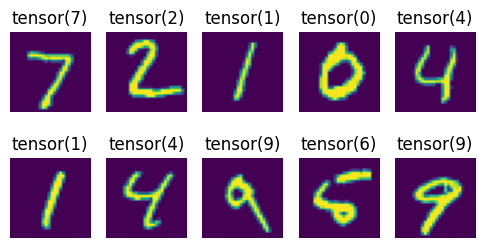

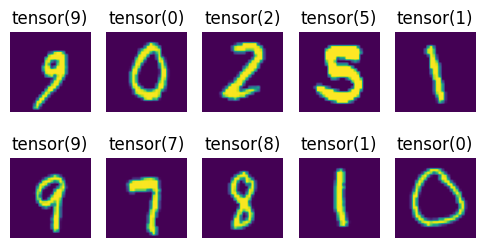

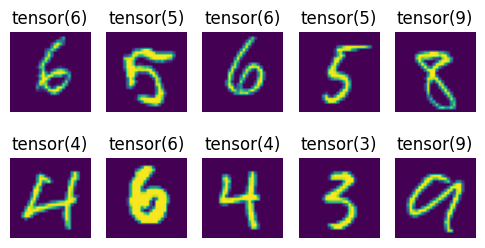

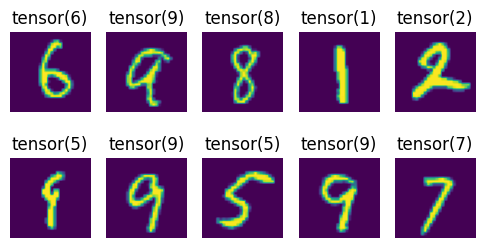

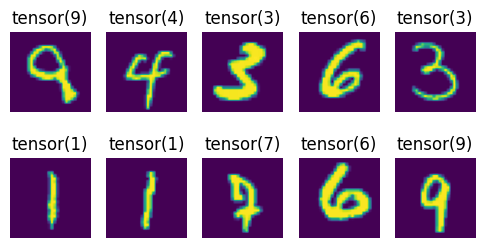

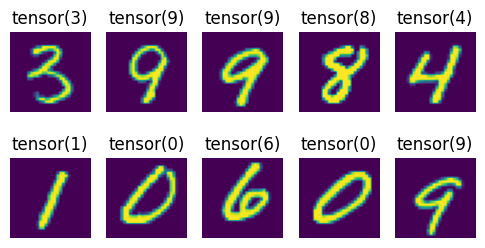

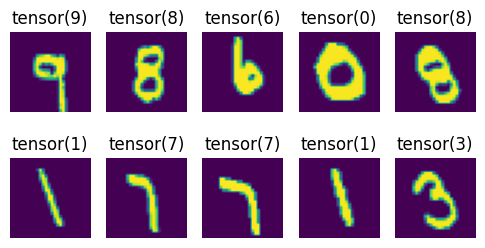

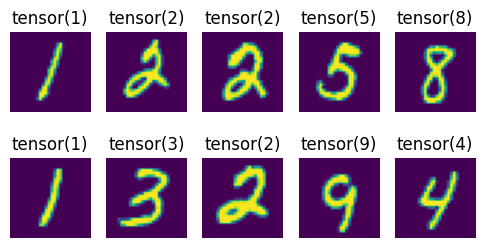

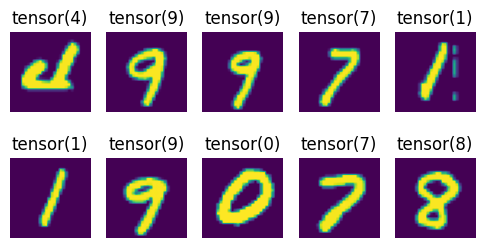

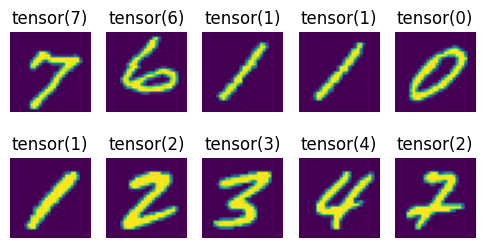

In [88]:
with torch.no_grad():
    base_model.eval()
    predictions = []
    for batch in test_loader:
        batch = batch[0]
        # make the predictions        
        outputs = base_model(batch).argmax(dim=-1)
        x = [x.detach().cpu().squeeze() for x in batch[:10]]
        y = [x.detach().cpu() for x in outputs[:10]]
        plot_images(x, captions=y)  
        predictions.extend(outputs.detach().cpu().tolist())


In [89]:
# save the predictions to a file
submission = pd.DataFrame(data={'id': list(range(len(predictions))),
                                'label': predictions})

sub_folder = os.path.join(script_dir, 'submissions')
submission.to_csv(os.path.join(sub_folder, f'sub_{len(os.listdir(sub_folder))}.csv'), index=False)